# Содержание

[Введение. Рекомендация тарифов для оператора мобильной связи](#1)

[1 Откроем файл с данными и изучим общую информацию.](#2)

[2 Разделим исходные данные на обучающую, валидационную и тестовую выборки.](#3)

[3 Исследуем качество разных моделей, меняя гиперпараметры.](#4)

[4 Проверим модель на тестовой выборке.](#5)

[5 Проверим модели на адекватность](#6)

[6 Общий вывод](#7)

[7 Чек-лист готовности проекта](#8)

<a id=1></a>
# Введение. Рекомендация тарифов для оператора мобильной связи

Оператор мобильной связи выяснил: многие клиенты пользуются архивными тарифами. И поэтому хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Цель исследования:**

Построить модель для задачи классификации, которая выберет подходящий тариф.

**Ход исследования:**

Данные для исследования я получу из файла — `users_behavior.csv`.

*Описание данных:*

`сalls` — количество звонков

`minutes` — суммарная длительность звонков в минутах

`messages` — количество sms-сообщений

`mb_used` — израсходованный интернет-трафик в Мб

`is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Таким образом, моё исследование пройдет в несколько этапов:

1. Откроем файл и проведем обзор данных.

2. Разделим исходные данные на обучающую, валидационную и тестовую выборки.

3. Исследуем качество разных моделей, меняя гиперпараметры.

4. Проверим качество модели на тестовой выборке.

5. Проверим модели на вменяемость.

6. Напишем общий вывод.

<a id=2></a>
## Откроем файл с данными и изучим общую информацию. 

### Считаем данные из csv-файла и сохраним в переменную.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [2]:
try:
    df = pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv('/datasets/users_behavior.csv')

### Выведем первые 5 строчек и общую информацию датафрейма `df` на экран.

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


### Построим гистограммы для всех числовых столбцов.

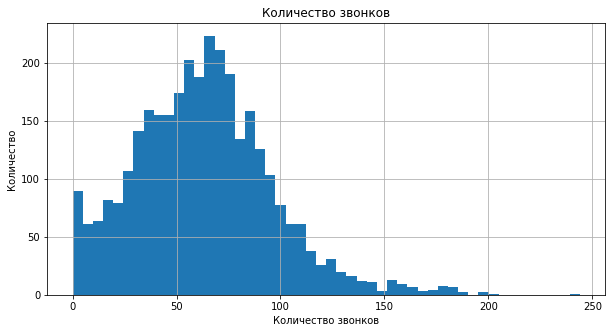

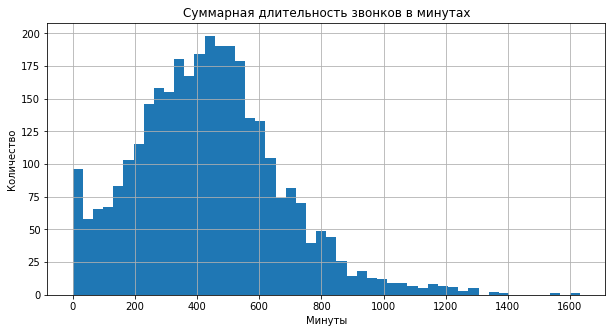

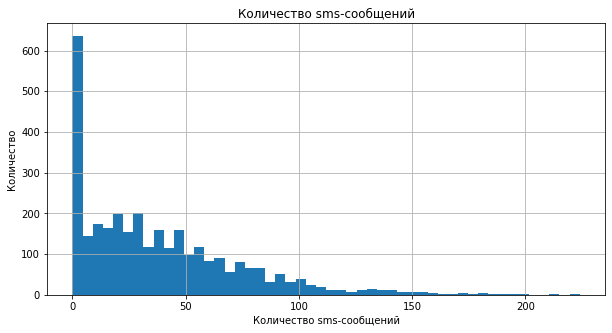

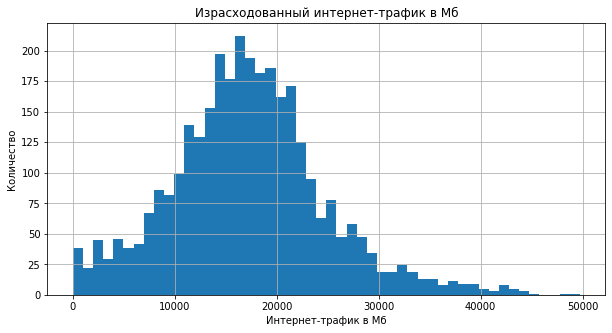

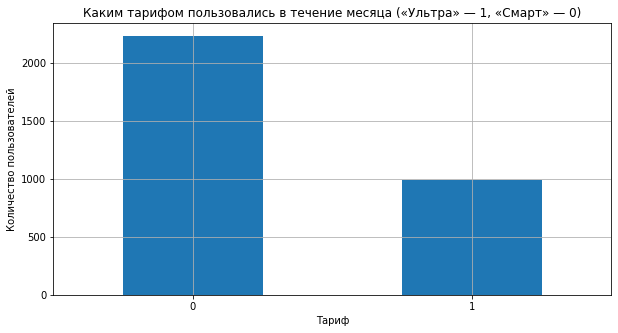

In [5]:
df.hist('calls', bins=50, figsize=(10, 5))
plt.title('Количество звонков')
plt.xlabel('Количество звонков')
plt.ylabel('Количество')
plt.show()

df.hist('minutes', bins=50, figsize=(10, 5))
plt.title('Cуммарная длительность звонков в минутах')
plt.xlabel('Минуты')
plt.ylabel('Количество')
plt.show()

df.hist('messages', bins=50, figsize=(10, 5))
plt.title('Количество sms-сообщений')
plt.xlabel('Количество sms-сообщений')
plt.ylabel('Количество')
plt.show()

df.hist('mb_used', bins=50, figsize=(10, 5))
plt.title('Израсходованный интернет-трафик в Мб')
plt.xlabel('Интернет-трафик в Мб')
plt.ylabel('Количество')
plt.show()

df.groupby('is_ultra')['is_ultra'].count().plot(
    x='is_ultra', 
    kind='bar', 
    figsize=(10, 5), 
    grid=True,
    title = 'Каким тарифом пользовались в течение месяца («Ультра» — 1, «Смарт» — 0)'
)
plt.xticks(rotation=0)
plt.xlabel('Тариф')
plt.ylabel('Количество пользователей')
plt.show()

### Проверим количество дубликатов в таблице `df`.

In [6]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


**Вывод, исходя из общих данных датафрейма `df`:**

1. пропусков нет;

2. дубликатов нет;

3. по гистограммам не видны какие-то большие разбросы данных или выбросы (если не считать гистограмму с sms-сообщениями, но кто их вообще до сих пор отправляет? Поэтому логично, что там на пике 0);

4. пользователи больше предпочитают тариф Смарт, чем Ультра, причем более чем в 2 раза.

**Данные готовы для дальнейшего исследования.**

<a id=3></a>
## Разделим исходные данные на обучающую, валидационную и тестовую выборки.

**Разделим сначала исходные данные на тренировочную (`df_train`)  и тестовую 1 (`df_test1`) выборки как 60% к 40% . Затем тестовую 1 разделим на тестовую (`df_test`) и валидационную (`df_valid`) в соотношении 50% на 50%. Так как наши исходные данные несбалансированные, то используем параметр - *stratify* (стратификация): разбиение на выборки, сохраняющее соотношение классов, представленное в исходном датасете.**

In [7]:
df_train, df_test1 =train_test_split(df, test_size=0.4, random_state=12345, stratify=df['is_ultra'])
df_test, df_valid=train_test_split(df_test1, test_size=0.5, random_state=12345, stratify=df_test1['is_ultra'])

In [8]:
print('Размер тренировочной выборки:', df_train.shape)
print('Размер валидационной выборки:', df_valid.shape)
print('Размер тестовой выборки:', df_test.shape)

Размер тренировочной выборки: (1928, 5)
Размер валидационной выборки: (643, 5)
Размер тестовой выборки: (643, 5)


**В итоге получили три выборки:**

1. Тренировочную выборку `df_train` - 60%

2. Валидационную выборку `df_valid` - 20%

3. Тестовую выборку `df_test` - 20%

**Проверим, что пропорции того, что на тарифе Смарт пользователей больше, чем на тарифе Ультра сохраняются и в наших выборках.**

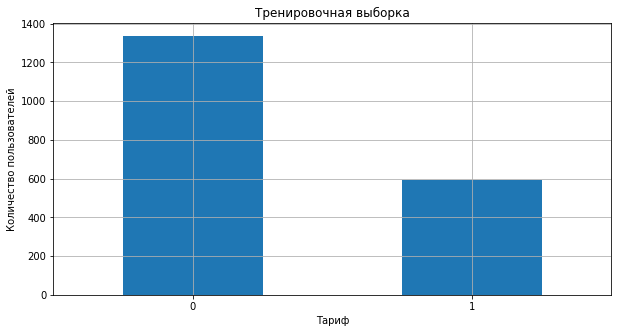

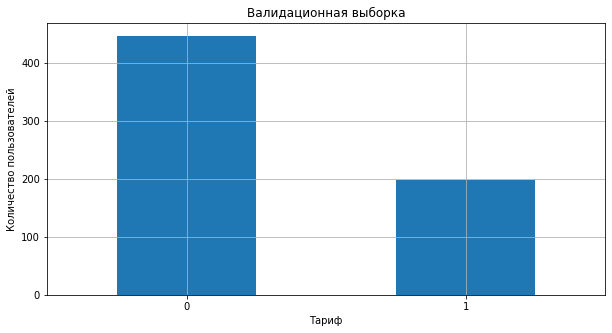

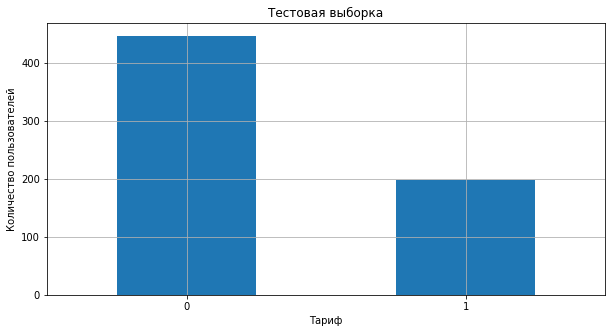

In [9]:
df_train.groupby('is_ultra')['is_ultra'].count().plot(
    x='is_ultra', 
    kind='bar', 
    figsize=(10, 5), 
    grid=True,
    title = 'Тренировочная выборка'
)
plt.xticks(rotation=0)
plt.xlabel('Тариф')
plt.ylabel('Количество пользователей')
plt.show()

df_valid.groupby('is_ultra')['is_ultra'].count().plot(
    x='is_ultra', 
    kind='bar', 
    figsize=(10, 5), 
    grid=True,
    title = 'Валидационная выборка'
)
plt.xticks(rotation=0)
plt.xlabel('Тариф')
plt.ylabel('Количество пользователей')
plt.show()

df_test.groupby('is_ultra')['is_ultra'].count().plot(
    x='is_ultra', 
    kind='bar', 
    figsize=(10, 5), 
    grid=True,
    title = 'Тестовая выборка'
)
plt.xticks(rotation=0)
plt.xlabel('Тариф')
plt.ylabel('Количество пользователей')
plt.show()

**Сохраним обучающий набор данных в переменных features (признаки) и target (целевой признак).**

In [10]:
#Для тренировочной выборки
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']

#Для валидационной выборки
features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

#Для тестовой выборки
features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']

**Вывод: Мы разделили исходные данные на обучающую, валидационную и тестовую выборки. А также разделили наборы данных на признаки и целевые признаки. Эти операции будут необходимы для дальнейшего исследования качества разных моделей и для итогового теста нашей модели.**

<a id=4></a>
## Исследуем качество разных моделей, меняя гиперпараметры.

### Начнем с `Дерева решений`, подберем оптимальный гиперпараметр *max_depth*.

In [11]:
best_model_DT = None
best_result_DT = 0
best_depth = 0
for depth in range(1, 100):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result > best_result_DT:
        best_model_DT = model # наилучшая модель
        best_result_DT = result # наилучшее значение метрики accuracy на валидационных данных
        best_depth = depth # лучшая глубина дерева

print("Accuracy наилучшей модели на валидационной выборке:", best_result_DT, "Лучшая глубина дерева:", best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.8118195956454122 Лучшая глубина дерева: 5


**Доля правильных ответов (*accuracy*) при глубине дерева 5 - наибольшая. Примем это значение гиперпараметра для нашей модели и алгоритма `Дерево решений`. Причем, было бы логично предположить, что если бы значение *accuracy* показало наибольшее значение при *max_depth* около 100, то такая модель могла бы страдать переобучением.**

### Попробуем алгоритм классификации — `Случайный лес`.

In [12]:
best_model_RF = None
best_result_RF = 0
best_est = 0
for est in range(1, 100):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid) # качество модели на валидационной выборке
    if result > best_result_RF:
        best_model_RF = model # наилучшая модель
        best_result_RF = result # наилучшее значение метрики accuracy на валидационных данных
        best_est = est # количество деревьев

print("Accuracy наилучшей модели на валидационной выборке:", best_result_RF, "Количество деревьев:", best_est)

Accuracy наилучшей модели на валидационной выборке: 0.8164852255054432 Количество деревьев: 75


**Доля правильных ответов (*accuracy*) при количестве деревьев 75 - наибольшая. Примем это значение гиперпараметра для нашей модели и алгоритма `Случайный лес`. Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования. `Случайный лес` помогает улучшить результат предсказания и избежать переобучения.**

### Попробуем алгоритм классификации — `Логистическая регрессия`.

In [13]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
model.predict(features_valid)
print("Accuracy на валидационной выборке:", model.score(features_valid, target_valid))

Accuracy на валидационной выборке: 0.7465007776049767


In [14]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model.fit(features_train, target_train)
model.predict(features_valid)
print("Accuracy на валидационной выборке:", model.score(features_valid, target_valid))

Accuracy на валидационной выборке: 0.7107309486780715


**Доля правильных ответов (*accuracy*) при `Логистической регрессии` намного меньше, чем у `Дерева решений` и `Случайного леса`. Смена алгоритмов решения lbfgs и liblinear практически не дали разницы.**

**Вывод:**

**Доля правильных ответов (*accuracy*) при использовании алгоритмов `Дерево решений` и `Случайный лес` практически одинаковая - более 81%. При этом известно, что самое высокое качество у `Случайного леса`: вместо одного `Дерева решений` используется целый лес. Но при этом страдает скорость решения. Нам скорость решения на данный момент не важна, но важно качество, поэтому выберем модель `Случайны лес`.**

<a id=5></a>
## Проверим модель на тестовой выборке.

**Используем алгоритм `Случайный лес` с найденным ранее параметром *n_estimators=75*:**

In [15]:
model = RandomForestClassifier(random_state=12345, n_estimators=75)
model.fit(features_train, target_train)
prediction_test = model.predict(features_test)
test_result = accuracy_score(target_test, prediction_test)
print("Случайный лес - Accuracy на тестовой выборке:", test_result)

Случайный лес - Accuracy на тестовой выборке: 0.7978227060653188


**Вывод: выбранная нами модель, использующая алгоритм `Случайный лес`, при тестовом прогоне показала долю правильных ответов (*accuracy*) практически равную доле при валидационной выборке. Модель не переобучена.** 

<a id=6></a>
## Проверим модели на вменяемость.

**Для этого используем модель `DummyClassifier`. Она представляет собой простейшую (dummy) модель, которая всегда предсказывает наиболее часто встречающийся класс. Так мы получим контрольные данные для сравнительной оценки построенной нами более сложной модели. К тому же мы сможем убедиться в качестве ее работы, например, в том, что она выдает не просто набор случайно подобранных данных.**

In [16]:
model_clf = DummyClassifier(strategy='most_frequent', random_state=12345)
model_clf.fit(features_train, target_train)
result_clf = model_clf.score(features_test, target_test)
print('Accuracy модели DummyClassifier:', result_clf)

Accuracy модели DummyClassifier: 0.6936236391912908


***Accuracy* модели `DummyClassifier` ниже, чем у модели `Случайный лес (RandomForestClassifier)` - модель вменяема и эффективна.**

<a id=7></a>
## Общий вывод.

На анализ была представлена таблица `users_behavior.csv`. Исходные данные таблицы были разделены на три выборки: обучающую, валидационную и тестовую. А также были разделены наборы данных на признаки и целевые признаки.

**Было проведено исследование качества трех разных моделей:**

1. `Дерево решений (DecisionTreeClassifier)`. Был найден максимально эффективный гиперпараметр *max_depth = 5 (глубина дерева решений)*, при которой модель показывала наибольшую долю правильных ответов (accuracy) = 81.2% на тестовой выборке.


2. `Случайный лес (RandomForestClassifier)`. Был найден максимально эффективный гиперпараметр *n_estimators = 75 (количество деревьев)*, при которой модель показывала наибольшую долю правильных ответов (accuracy) = 81.6% на тестовой выборке.


3. `Логистическая регрессия (LogisticRegression)`. Были рассмотрены два алгоритма решения - *lbfgs* и *liblinear*, но доля правильных ответов у данной модели все равно меньше, чем у двух предыдущих - 74.7% и 71.1% на тестовой выборке.

Таким образом, наиболее точный прогноз дает модель `Случайный лес`. Так как мы имеем несбалансированные исходные данные (людей на тарифе Смарт изначально намного больше, чем на тарифе Ультра), то `Случайный лес` отлично подходит для решения таких задач, так как алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования.

Также модель `Случайный лес` была проверена на вменяемость - для проверки использовалась простейшая модель `DummyClassifier`, которая показала результат Accuracy - 69.4%, что меньше полученнных тестовых значений нашей модели, значит наша модель вменяема и эффективна.